In [1]:
import torch, math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
!pip install torchsummary
from torchsummary import summary
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
!pip install torchsummary
from torchsummary import summary
!pip install einops
from math import ceil
# !pip install nystrom-attention
!pip install performer_pytorch

from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from einops import rearrange, reduce

# helpers
from einops import reduce

transform = transforms.Compose(
        [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 192

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def accuracy(output, target, topk=(1,5)):
    """Computes the precision@k for the specified values of k
    prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
    """
    maxk = max(topk)
         # sizefunction: the number of total elements
    batch_size = target.size(0) 
 
         # topk function selects the number of k before output
    _, pred = output.topk(maxk, 1, True, True)
         ##########Do not understand t()k
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))   
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-py3-none-any.whl size=2902 sha256=41e4bf22a0121c1d241c83c167a5aec9e7f35cdb9fc3c5ddaeb346a1572fb26e
  Stored in directory: /root/.cache/pip/wheels/4a/2c/c3/9a1cb267c0d0d9b6eeba7952addb32b17857d1f799690c27a8
Successfully built axial-positional-embedding


0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
from torch.cuda.amp import autocast
from functools import partial
from contextlib import contextmanager
from local_attention import LocalAttention
from axial_positional_embedding import AxialPositionalEmbedding
from performer_pytorch.reversible import ReversibleSequence, SequentialSequence

def exists(val):
    return val is not None

def empty(tensor):
    return tensor.numel() == 0

def default(val, d):
    return val if exists(val) else d

@contextmanager
def null_context():
    yield

def rotate_every_two(x):
    x = rearrange(x, '... (d j) -> ... d j', j = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d j -> ... (d j)')

def apply_rotary_pos_emb(q, k, sinu_pos):
    sinu_pos = rearrange(sinu_pos, '() n (j d) -> n j d', j = 2)
    sin, cos = sinu_pos.unbind(dim = -2)

    sin, cos = map(lambda t: repeat(t, 'b n -> b (n j)', j = 2), (sin, cos))
    q, k = map(lambda t: (t * cos) + (rotate_every_two(t) * sin), (q, k))
    return q, k

class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        position = torch.arange(0, max_seq_len, dtype=torch.float)
        sinusoid_inp = torch.einsum("i,j->ij", position, inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        self.register_buffer('emb', emb)

    def forward(self, x):
        return self.emb[None, :x.shape[1], :].to(x)
# def cast_tuple(val):
#     return (val,) if not isinstance(val, tuple) else val

def get_module_device(module):
    return next(module.parameters()).device

def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

class Always(nn.Module):
    def __init__(self, val):
        super().__init__()
        self.val = val

    def forward(self, *args, **kwargs):
        return self.val

# kernel functions

# transcribed from jax to pytorch from
# https://github.com/google-research/google-research/blob/master/performer/fast_attention/jax/fast_attention.py

def softmax_kernel(data, *, projection_matrix, is_query, normalize_data=True, eps=1e-4, device = None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    ratio = (projection_matrix.shape[0] ** -0.5)

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('...id,...jd->...ij', (data_normalizer * data), projection)

    diag_data = data ** 2
    diag_data = torch.sum(diag_data, dim=-1)
    diag_data = (diag_data / 2.0) * (data_normalizer ** 2)
    diag_data = diag_data.unsqueeze(dim=-1)

    if is_query:
        data_dash = ratio * (
            torch.exp(data_dash - diag_data -
                    torch.max(data_dash, dim=-1, keepdim=True).values) + eps)
    else:
        data_dash = ratio * (
            torch.exp(data_dash - diag_data - torch.max(data_dash)) + eps)

    return data_dash.type_as(data)

def generalized_kernel(data, *, projection_matrix, kernel_fn = nn.ReLU(), kernel_epsilon = 0.001, normalize_data = True, device = None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    if projection_matrix is None:
        return kernel_fn(data_normalizer * data) + kernel_epsilon

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('...id,...jd->...ij', (data_normalizer * data), projection)

    data_prime = kernel_fn(data_dash) + kernel_epsilon
    return data_prime.type_as(data)

def orthogonal_matrix_chunk(cols, device = None):
    unstructured_block = torch.randn((cols, cols), device = device)
    q, r = torch.qr(unstructured_block.cpu(), some = True)
    q, r = map(lambda t: t.to(device), (q, r))
    return q.t()

def gaussian_orthogonal_random_matrix(nb_rows, nb_columns, scaling = 0, device = None):
    nb_full_blocks = int(nb_rows / nb_columns)

    block_list = []

    for _ in range(nb_full_blocks):
        q = orthogonal_matrix_chunk(nb_columns, device = device)
        block_list.append(q)

    remaining_rows = nb_rows - nb_full_blocks * nb_columns
    if remaining_rows > 0:
        q = orthogonal_matrix_chunk(nb_columns, device = device)
        block_list.append(q[:remaining_rows])

    final_matrix = torch.cat(block_list)

    if scaling == 0:
        multiplier = torch.randn((nb_rows, nb_columns), device = device).norm(dim = 1)
    elif scaling == 1:
        multiplier = math.sqrt((float(nb_columns))) * torch.ones((nb_rows,), device = device)
    else:
        raise ValueError(f'Invalid scaling {scaling}')

    return torch.diag(multiplier) @ final_matrix

# linear attention classes with softmax kernel

# non-causal linear attention
def linear_attention(q, k, v):
    k_cumsum = k.sum(dim = -2)
    D_inv = 1. / torch.einsum('...nd,...d->...n', q, k_cumsum.type_as(q))
    context = torch.einsum('...nd,...ne->...de', k, v)
    out = torch.einsum('...de,...nd,...n->...ne', context, q, D_inv)
#     print("linear attention", out.size)
    return out

class FastAttention(nn.Module):
    def __init__(self, dim_heads, nb_features = None, ortho_scaling = 0, causal = False, generalized_attention = False, kernel_fn = nn.ReLU(), no_projection = False):
        super().__init__()
        nb_features = default(nb_features, int(dim_heads * math.log(dim_heads)))

        self.dim_heads = dim_heads
        self.nb_features = nb_features
        self.ortho_scaling = ortho_scaling

        self.create_projection = partial(gaussian_orthogonal_random_matrix, nb_rows = self.nb_features, nb_columns = dim_heads, scaling = ortho_scaling)
        projection_matrix = self.create_projection()
        self.register_buffer('projection_matrix', projection_matrix)

        self.generalized_attention = generalized_attention
        self.kernel_fn = kernel_fn

        # if this is turned on, no projection will be used
        # queries and keys will be softmax-ed as in the original efficient attention paper
        self.no_projection = no_projection

        self.causal = causal
        
    @torch.no_grad()
    def redraw_projection_matrix(self, device):
        projections = self.create_projection(device = device)
        self.projection_matrix.copy_(projections)
        del projections

    def forward(self, q, k, v):
        device = q.device
        
        if self.no_projection:
            q = q.softmax(dim = -1)
            k = torch.exp(k) if self.causal else k.softmax(dim = -2)

        elif self.generalized_attention:
            create_kernel = partial(generalized_kernel, kernel_fn = self.kernel_fn, projection_matrix = self.projection_matrix, device = device)
            q, k = map(create_kernel, (q, k))

        else:
            create_kernel = partial(softmax_kernel, projection_matrix = self.projection_matrix, device = device)
            q = create_kernel(q, is_query = True)
            k = create_kernel(k, is_query = False)

        attn_fn = linear_attention if not self.causal else self.causal_linear_fn
        out = attn_fn(q, k, v)
#         print('fastattention', out.size())
        return out

# a module for keeping track of when to update the projections

class ProjectionUpdater(nn.Module):
    def __init__(self, instance, feature_redraw_interval):
        super().__init__()
        self.instance = instance
        self.feature_redraw_interval = feature_redraw_interval
        self.register_buffer('calls_since_last_redraw', torch.tensor(0))

    def fix_projections_(self):
        self.feature_redraw_interval = None

    def redraw_projections(self):
        model = self.instance

        if not self.training:
            return

        if exists(self.feature_redraw_interval) and self.calls_since_last_redraw >= self.feature_redraw_interval:
            device = get_module_device(model)

            fast_attentions = find_modules(model, FastAttention)
            for fast_attention in fast_attentions:
                fast_attention.redraw_projection_matrix(device)

            self.calls_since_last_redraw.zero_()
            return

        self.calls_since_last_redraw += 1

    def forward(self, x):
        raise NotImplemented

# classes

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        causal = False,
        heads = 4,
        dim_head = 32,
        local_heads = 0,
        local_window_size = 256,
        nb_features = None,
        feature_redraw_interval = 1000,
        generalized_attention = False,
        kernel_fn = nn.ReLU(),
        dropout = 0.,
        no_projection = False,
        qkv_bias = False,
        attn_out_bias = True
    ):
        super().__init__()
        assert dim % heads == 0, 'dimension must be divisible by number of heads'
        dim_head = default(dim_head, dim // heads)
        inner_dim = dim_head * heads
        self.fast_attention = FastAttention(dim_head, nb_features, causal = causal, generalized_attention = generalized_attention, kernel_fn = kernel_fn, no_projection = no_projection)

        self.heads = heads
        self.global_heads = heads - local_heads
        self.local_attn = LocalAttention(window_size = local_window_size, causal = causal, autopad = True, dropout = dropout, look_forward = int(not causal), rel_pos_emb_config = (dim_head, local_heads)) if local_heads > 0 else None

        self.to_q = nn.Linear(dim, inner_dim, bias = qkv_bias)
        self.to_k = nn.Linear(dim, inner_dim, bias = qkv_bias)
        self.to_v = nn.Linear(dim, inner_dim, bias = qkv_bias)
        self.to_out = nn.Linear(inner_dim, dim, bias = attn_out_bias)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x, pos_emb = None, context = None, mask = None, context_mask = None, **kwargs):
        
        b, n, _, h, gh = *x.shape, self.heads, self.global_heads

        cross_attend = exists(context)

        context = default(context, x)
        context_mask = default(context_mask, mask) if not cross_attend else context_mask

        q, k, v = self.to_q(x), self.to_k(context), self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))
        (q, lq), (k, lk), (v, lv) = map(lambda t: (t[:, :gh], t[:, gh:]), (q, k, v))

        attn_outs = []

        if not empty(q):
            if exists(context_mask):
                global_mask = context_mask[:, None, :, None]
                v.masked_fill_(~global_mask, 0.)

            if exists(pos_emb) and not cross_attend:
                q, k = apply_rotary_pos_emb(q, k, pos_emb)
                

            out = self.fast_attention(q, k, v)
            attn_outs.append(out)


        if not empty(lq):
            assert not cross_attend, 'local attention is not compatible with cross attention'
            out = self.local_attn(lq, lk, lv, input_mask = mask)
            attn_outs.append(out)

        out = torch.cat(attn_outs, dim = 1)
        out = rearrange(out, 'b h n d -> b n (h d)')
#         print("Attention", out.size())
        out =  self.to_out(out)
        out = self.dropout(out)
        return out


class SelfAttention(Attention):
    def forward(self, *args, pos_emb, context = None, **kwargs):
        assert not exists(context), 'self attention should not receive context'
#         print(1, "self attention module")
        return super().forward(*args, pos_emb, **kwargs)

In [3]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        local_attn_heads = 0
        local_window_size = 256
        causal = False
        nb_features = None
        generalized_attention = False
        kernel_fn = nn.ReLU()
        attn_dropout = 0.
        no_projection = False
        qkv_bias = True
        attn_out_bias = True
#           self.pos_emb = AxialRotaryEmbedding(dim_head)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, SelfAttention(dim, causal = causal, heads = heads, dim_head = dim_head, local_heads = local_attn_heads, local_window_size = local_window_size, nb_features = nb_features, generalized_attention = generalized_attention, kernel_fn = kernel_fn, dropout = attn_dropout, no_projection = no_projection, qkv_bias = qkv_bias, attn_out_bias = attn_out_bias)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x, pos_emb):
#         pos_emb = self.pos_emb(x[:, 1:])
        for attn, ff in self.layers:
            x = attn(x, pos_emb = pos_emb) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0., rotary_position_emb = True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        self.patch_size = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
        
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim)

        )

#         self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        max_seq_len = 1025
        if rotary_position_emb:
            self.layer_pos_emb = FixedPositionalEmbedding(dim_head, max_seq_len)

    def forward(self, img):
        b, _, h, w, p = *img.shape, self.patch_size
        x = self.to_patch_embedding(img)
#         b, n, _ = x.shape
        n = x.shape[1]

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        
        x = torch.cat((cls_tokens, x), dim=1)
#         x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
#         fmap_dims = {'h': h // p, 'w': w // p}
        layer_pos_emb = self.layer_pos_emb(x)
        x = self.transformer(x, pos_emb = layer_pos_emb)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [4]:

model = ViT(
    image_size = 32,
    patch_size = 1,
    num_classes = 10,             # number of stages
    dim = 128,  # dimensions at each stage
    depth = 4,              # transformer of depth 4 at each stage
    heads = 4,      # heads at each stage
    mlp_dim = 256,
    dropout = 0.,
    dim_head = 32
)


model.to(device)
print(summary(model, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [-1, 1024, 3]               0
            Linear-2            [-1, 1024, 128]             512
           Dropout-3            [-1, 1025, 128]               0
FixedPositionalEmbedding-4             [-1, 1025, 32]               0
         LayerNorm-5            [-1, 1025, 128]             256
            Linear-6            [-1, 1025, 128]          16,512
            Linear-7            [-1, 1025, 128]          16,512
            Linear-8            [-1, 1025, 128]          16,512
     FastAttention-9          [-1, 4, 1025, 32]               0
           Linear-10            [-1, 1025, 128]          16,512
          Dropout-11            [-1, 1025, 128]               0
    SelfAttention-12            [-1, 1025, 128]               0
          PreNorm-13            [-1, 1025, 128]               0
        LayerNorm-14            [

In [5]:
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
top1 = []
top5 = []
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
for epoch in range(40):  # loop over the dataset multiple times
    t0 = time.time()
    epoch_accuracy = 0
    epoch_loss = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        with torch.cuda.amp.autocast():
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    correct = 0
    total = 0
    correct_1=0
    correct_5=0
    c = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
#         outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            res = accuracy(outputs, labels)
            correct_1 += res[0][0].float()
            correct_5 += res[1][0].float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c += 1
        
    print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - Top 1: {correct_1/c} - Top 5: {correct_5/c} - Time: {time.time() - t0}\n")
    top1.append(correct_1/c)
    top5.append(correct_5/c)
    if float(correct_1/c) >= float(max(top1)):
        PATH = 'ViPRoPE.pth'
        torch.save(model.state_dict(), PATH)
        print(1)
print('Finished Training')

[1,   200] loss: 0.186
Epoch : 1 - loss : 1.8206 - acc: 0.3315 - Top 1: 41.08687210083008 - Top 5: 88.85613250732422 - Time: 233.35399413108826

1
[2,   200] loss: 0.159
Epoch : 2 - loss : 1.5798 - acc: 0.4261 - Top 1: 46.31486511230469 - Top 5: 91.06721496582031 - Time: 233.5240466594696

1
[3,   200] loss: 0.148
Epoch : 3 - loss : 1.4724 - acc: 0.4678 - Top 1: 49.81328201293945 - Top 5: 92.43318176269531 - Time: 233.6376657485962

1
[4,   200] loss: 0.141
Epoch : 4 - loss : 1.4044 - acc: 0.4917 - Top 1: 48.211483001708984 - Top 5: 92.41351318359375 - Time: 233.70439553260803

[5,   200] loss: 0.135
Epoch : 5 - loss : 1.3427 - acc: 0.5159 - Top 1: 51.975242614746094 - Top 5: 93.63208770751953 - Time: 233.52467346191406

1
[6,   200] loss: 0.129
Epoch : 6 - loss : 1.2891 - acc: 0.5345 - Top 1: 52.781063079833984 - Top 5: 94.38875579833984 - Time: 233.72939014434814

1
[7,   200] loss: 0.125
Epoch : 7 - loss : 1.2438 - acc: 0.5510 - Top 1: 56.29914855957031 - Top 5: 94.86046600341797 - 

KeyboardInterrupt: 

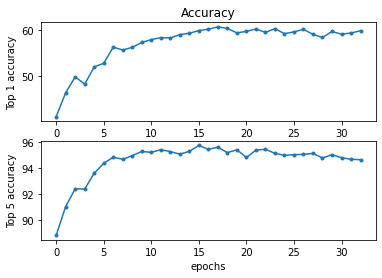

In [7]:
plt.subplot(2, 1, 1)
plt.plot(top1, '.-')
plt.title('Accuracy')
plt.ylabel('Top 1 accuracy')

plt.subplot(2, 1, 2)
plt.plot(top5, '.-')
plt.xlabel('epochs')
plt.ylabel('Top 5 accuracy')

plt.show()
